## Análisis de datos - Clase 6

### Taller práctico - análisis completo de un dataset - parte 2

In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA

#### Importo el dataset

In [452]:
# Leer el JSON
with open("../datasets/carreras_24_2_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
carreras_24 = pd.read_csv("../datasets/carreras_24_2.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    carreras_24[col] = pd.to_timedelta(carreras_24[col])

# Restaurar categoricals
for col in categorical_cols:
    carreras_24[col] = carreras_24[col].astype("category")


# Le cambio el tipo para hacer cuentas luego
carreras_24['Position']=carreras_24['Position'].astype('Int64')

carreras_24.head()

,EventName,EventDate,Driver,DriverNumber,Team,PitInTime,PitOutTime,IsPersonalBest,Stint,LapTime,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,PitOutTime2,PitTime,PitTime_seconds,Pit
0,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,False,1.0,101.190,...,12,16,False,NotDeleted,False,False,NaT,NaT,0.0,False
1,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,120.191,...,26,15,False,NotDeleted,False,False,NaT,NaT,0.0,False
2,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,95.776,...,671,15,False,NotDeleted,False,False,NaT,NaT,0.0,False
3,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,90.060,...,1,15,False,NotDeleted,False,True,NaT,NaT,0.0,False
4,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,False,1.0,90.369,...,1,15,False,NotDeleted,False,True,NaT,NaT,0.0,False


In [453]:
carreras_24.columns

Index(['EventName', 'EventDate', 'Driver', 'DriverNumber', 'Team', 'PitInTime',
       'PitOutTime', 'IsPersonalBest', 'Stint', 'LapTime', 'LapNumber',
       'LapStartTime', 'LapStartDate', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'AirTemp',
       'TrackTemp', 'Humidity', 'Compound', 'TyreLife', 'FreshTyre',
       'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'PitOutTime2', 'PitTime',
       'PitTime_seconds', 'Pit'],
      dtype='object')

In [454]:
# Métricas por piloto y por carrera
result = carreras_24.groupby(['Driver', 'EventName'], observed=True).agg(
    Event_date=('EventDate','first' ),
    Team=('Team','first'),
    Position_start=('Position', 'first'),
    Position_end=('Position', 'last'),
    Avg_LapTime=('LapTime', 'mean'),
    Fastest_LapTime=('LapTime', 'min'),
    #Total_RaceTime=('LapTime', 'sum'),
    Tyre_Compound_start=('Compound', 'first'),
    #Tyre_Compound_end=('Compound', 'last'),
    #Total_PitTime=('PitTime_seconds', 'sum'), # Total de tiempo en boxes
    #Pit_Stops=('PitInTime', lambda x: x.notna().sum()),
    Avg_TrackTemp=('TrackTemp', 'mean'),
    Avg_AirTemp=('AirTemp', 'mean'),
    Avg_Humidity=('Humidity', 'mean'),

).reset_index()


# Agrego el ganador
result['Winner']= np.where(result['Position_end']==1,1,0)
result = result.drop('Position_end', axis=1)

result.head()

,Driver,EventName,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,Tyre_Compound_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,ALB,Abu Dhabi Grand Prix,2024-12-08,Williams,16,91.307754,89.438,MEDIUM,30.682456,26.424561,54.894737,0
1,ALB,Australian Grand Prix,2024-03-24,Williams,14,84.769333,81.618,MEDIUM,38.550877,21.201754,43.245614,0
2,ALB,Austrian Grand Prix,2024-06-30,Williams,15,72.480914,70.364,MEDIUM,46.418571,29.724286,34.328571,0
3,ALB,Azerbaijan Grand Prix,2024-09-15,Williams,9,111.086333,106.947,HARD,43.356863,26.501961,37.019608,0
4,ALB,Bahrain Grand Prix,2024-03-02,Williams,11,98.511214,95.723,SOFT,22.828571,18.012500,49.928571,0


In [455]:
# Verifico que quedó bien esta col
result[result['Winner']==1].head()

,Driver,EventName,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,Tyre_Compound_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
110,HAM,British Grand Prix,2024-07-07,Mercedes,3,95.135750,89.438,MEDIUM,24.101923,15.634615,67.576923,1
169,LEC,Italian Grand Prix,2024-09-01,Ferrari,2,84.542019,83.226,MEDIUM,46.550943,32.790566,31.509434,1
174,LEC,Monaco Grand Prix,2024-05-26,Ferrari,1,109.071436,75.162,MEDIUM,44.594872,21.835897,61.384615,1
180,LEC,United States Grand Prix,2024-10-20,Ferrari,1,101.957839,97.834,MEDIUM,47.126786,28.598214,33.821429,1
202,NOR,Abu Dhabi Grand Prix,2024-12-08,McLaren,1,89.539500,87.438,MEDIUM,30.713793,26.427586,54.862069,1


In [456]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Driver               465 non-null    category      
 1   EventName            465 non-null    category      
 2   Event_date           465 non-null    datetime64[ns]
 3   Team                 465 non-null    category      
 4   Position_start       465 non-null    Int64         
 5   Avg_LapTime          465 non-null    float64       
 6   Fastest_LapTime      465 non-null    float64       
 7   Tyre_Compound_start  465 non-null    category      
 8   Avg_TrackTemp        465 non-null    float64       
 9   Avg_AirTemp          465 non-null    float64       
 10  Avg_Humidity         465 non-null    float64       
 11  Winner               465 non-null    int64         
dtypes: Int64(1), category(4), datetime64[ns](1), float64(5), int64(1)
memory usage: 33.5 KB


---
### Preparación para entrenamiento de un modelo de ML
---

#### Suponemos que queremos predecir quién va a ganar las próximas carreras y plantearemos un problema de clasificación binaria usando la variable "Winner" como target.

---
### 1. Split del dataset
---

#### El split del dataset no lo debería hacer en forma aleatoria, porque tengo una fila por cada piloto para cada evento. Si hago un split random, puede que me queden filas para un mismo evento en test y train, y estaría haciendo data leakage. 
#### Para evitar esto, puedo hacer el split a partir de un cierto evento (por fecha). Un 80-20 se conseguiría tomando X_train = primeros 19 eventos del 2024 y X_test = últimos 5 eventos.

In [457]:
# Primero, ordeno los datos por fecha
result = result.sort_values('Event_date').reset_index(drop=True)

result.head()

,Driver,EventName,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,Tyre_Compound_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,VER,Bahrain Grand Prix,2024-03-02,Red Bull Racing,1,96.574421,92.608,SOFT,22.829825,18.008772,49.912281,1
1,STR,Bahrain Grand Prix,2024-03-02,Aston Martin,19,98.209789,95.632,SOFT,22.817544,18.007018,49.964912,0
2,RUS,Bahrain Grand Prix,2024-03-02,Mercedes,3,97.395263,95.065,SOFT,22.828070,18.008772,49.912281,0
3,PER,Bahrain Grand Prix,2024-03-02,Red Bull Racing,4,96.968404,94.364,SOFT,22.828070,18.005263,49.912281,0
4,NOR,Bahrain Grand Prix,2024-03-02,McLaren,7,97.424561,94.476,SOFT,22.826316,18.008772,49.912281,0


In [458]:
# Ordeno las fechas para hacer el split
np.sort(result['Event_date'].unique())

array(['2024-03-02T00:00:00.000000000', '2024-03-09T00:00:00.000000000',
       '2024-03-24T00:00:00.000000000', '2024-04-07T00:00:00.000000000',
       '2024-04-21T00:00:00.000000000', '2024-05-05T00:00:00.000000000',
       '2024-05-19T00:00:00.000000000', '2024-05-26T00:00:00.000000000',
       '2024-06-09T00:00:00.000000000', '2024-06-23T00:00:00.000000000',
       '2024-06-30T00:00:00.000000000', '2024-07-07T00:00:00.000000000',
       '2024-07-21T00:00:00.000000000', '2024-07-28T00:00:00.000000000',
       '2024-08-25T00:00:00.000000000', '2024-09-01T00:00:00.000000000',
       '2024-09-15T00:00:00.000000000', '2024-09-22T00:00:00.000000000',
       '2024-10-20T00:00:00.000000000', '2024-10-27T00:00:00.000000000',
       '2024-11-03T00:00:00.000000000', '2024-11-23T00:00:00.000000000',
       '2024-12-01T00:00:00.000000000', '2024-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [459]:
# Hago un split preliminar
fecha_split = pd.Timestamp('2024-10-27')
data_train = result[result['Event_date'] < fecha_split].copy()
data_test = result[result['Event_date'] >= fecha_split].copy()

# Datos para train
y_train = data_train['Winner'].copy()
X_train = data_train.drop(['Winner'], axis=1)

# Datos para test
y_test = data_test['Winner'].copy()
X_test = data_test.drop(['Winner'], axis=1)

# Verifico el split
print(f"últimas 5 filas de X_train: \n{X_train['Event_date'].tail()}\n")
print(f"primeras 5 filas de X_test: \n{X_test['Event_date'].head()}")

últimas 5 filas de X_train: 
367   2024-10-20
368   2024-10-20
369   2024-10-20
370   2024-10-20
371   2024-10-20
Name: Event_date, dtype: datetime64[ns]

primeras 5 filas de X_test: 
372   2024-10-27
373   2024-10-27
374   2024-10-27
375   2024-10-27
376   2024-10-27
Name: Event_date, dtype: datetime64[ns]


In [460]:
X_train.columns

Index(['Driver', 'EventName', 'Event_date', 'Team', 'Position_start',
       'Avg_LapTime', 'Fastest_LapTime', 'Tyre_Compound_start',
       'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity'],
      dtype='object')

In [461]:
# Saco Event_date porque ya no me sirve (la usé solo para filtrar)
if 'Event_date' in X_train.columns:
    X_train = X_train.drop(['Event_date'], axis=1)
if 'Event_date' in X_test.columns:
    X_test = X_test.drop(['Event_date'], axis=1)

print(f"Dimensiones de X_train:{X_train.shape}")
print(f"Dimensiones de y_train:{y_train.shape}")
print(f"Dimensiones de X_test:{X_test.shape}")
print(f"Dimensiones de y_test:{y_test.shape}")

Dimensiones de X_train:(372, 10)
Dimensiones de y_train:(372,)
Dimensiones de X_test:(93, 10)
Dimensiones de y_test:(93,)


 ---
 #### 2. En un escenario real, ahora haríamos el tratamiento de nulos y outliers. En este caso no lo vamos a hacer porque no es el foco de esta parte del trabajo.
 ---


---
#### 3. Encoding y normalización de las variables
---

#### Scikit-learn tiene una función muy interesante que arma una pipeline para hacer el procesamiento más fácil y en un solo paso. A continuación vamos a mostrar cómo la utilizaríamos en este caso.

In [463]:
# Features categóricos
onehot_cols = ['Team', 'Tyre_Compound_start'] # Para los de baja cardinalidad
target_enc_cols = ['Driver', 'EventName'] # Alta cardinalidad, EventName va a incluir eventos futuros

# Numerical features for scaling
numericas = [
    'Position_start',
    'Avg_LapTime',       
    'Fastest_LapTime',   
    'Avg_TrackTemp',
    'Avg_AirTemp',
    'Avg_Humidity'
]

# Verificar que no haya overlap 
assert set(onehot_cols).isdisjoint(set(target_enc_cols))
assert set(onehot_cols).isdisjoint(set(numericas))
assert set(target_enc_cols).isdisjoint(set(numericas))

In [464]:
# Definir la pipeline

# Pasos de encoding para las distintas col
codificar_escalar = ColumnTransformer(
    transformers=[
        # One-Hot encoding
        ('onehot',
         OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         onehot_cols),

        # Target Encoding como definimos arriba
        ('target_encode',
         TargetEncoder(), # La configuración default maneja valores no vistos antes usando la media global
         target_enc_cols),

        # Escalamiento para las numéricas
        ('scaler',
         MinMaxScaler(),
         numericas)
    ],
    remainder='passthrough' # Qué hacer si aparecen columnas nuevas
)

# Create a full pipeline (preprocessing + a placeholder model)
# You can remove the model part if you only want the preprocessor
model_pipeline = Pipeline(steps=[
    ('preprocessor', codificar_escalar),
    # ('classifier', RandomForestClassifier()) # Acá podríamos agregar el modelo
])

print(model_pipeline)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Team',
                                                   'Tyre_Compound_start']),
                                                 ('target_encode',
                                                  TargetEncoder(),
                                                  ['Driver', 'EventName']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Position_start',
                                                   'Avg_LapTime',
                                                   'Fastest_LapTime',
                                              

In [465]:
# Hacemos el fit de la pipeline

# Hacemos el Fit de la pipeline solo en X_train 
# Nota: el TargetEncoder va a necesitar y_train al momento de hacer el fit
X_train_procesado = model_pipeline.fit_transform(X_train, y_train)

# Transformamos los datos de test con la pipeline ya fitteada
X_test_procesado = model_pipeline.transform(X_test)

print(f"\nShape of X_train_procesado: {X_train_procesado.shape}")
print(f"Shape of X_test_procesado: {X_test_procesado.shape}")


Shape of X_train_procesado: (372, 23)
Shape of X_test_procesado: (93, 23)


In [466]:
# Miramos cómo quedó
pd.DataFrame(X_train_procesado)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.201821,0.050538,0.000000,0.503877,0.463439,0.000486,0.131513,0.427318
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.026813,0.050538,0.947368,0.536489,0.519690,0.000043,0.131416,0.428516
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.076816,0.050538,0.105263,0.520246,0.509143,0.000422,0.131513,0.427318
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.028083,0.050538,0.157895,0.511734,0.496103,0.000422,0.131318,0.427318
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.101817,0.050538,0.315789,0.520830,0.498186,0.000359,0.131513,0.427318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.051815,0.050538,0.578947,0.733000,0.750944,0.854628,0.656839,0.156114
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.042496,0.050538,0.789474,0.636864,0.556502,0.876537,0.718118,0.060169
369,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.076816,0.050538,0.947368,0.631279,0.557339,0.876666,0.718118,0.060169
370,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.028083,0.050538,0.263158,0.641699,0.569523,0.877053,0.718216,0.060982


---
#### 4. Selección de features
---

In [ ]:
# Falta completar - esto se puede agregar a la pipeline

---
#### 5. Extracción de features
---

In [ ]:
# Falta completar - esto también se puede agregar a la pipeline
# Revisar porque da raro

# Aplicar PCA
pca = PCA(n_components=6)
components = pca.fit_transform(X_train_procesado)

# Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6'])

# # (Opcional) Información adicional: Driver, Team, etc.
# df_components['Driver'] = carreras_24.loc[df_pca, 'Driver'].values
# df_components['Team'] = carreras_24.loc[df_pca, 'Team'].values
# df_components['EventName'] = carreras_24.loc[df_pca.index, 'EventName'].values
df_components['Winner'] = y_train


In [468]:
df_components

,PC1,PC2,PC3,PC4,PC5,PC6,Winner
0,-0.832260,-0.671221,-0.662394,-0.163941,-0.005629,0.042636,1
1,-1.124065,-0.305684,-0.025583,0.360650,0.340265,0.652213,0
2,-0.907736,-0.619018,-0.604035,0.013762,-0.353580,-0.497950,0
3,-0.865838,-0.621615,-0.569099,-0.120895,-0.005891,0.045464,0
4,-0.839676,-0.668924,-0.497139,0.134012,0.631945,-0.322601,0
...,...,...,...,...,...,...,...
367,-0.437259,0.917093,-0.305693,-0.694790,-0.365549,-0.460564,0
368,-0.444457,1.126385,0.157051,-0.294862,-0.008834,0.033417,0
369,-0.481355,1.094334,-0.219833,-0.553851,-0.355886,-0.468541,0
370,0.581352,0.341421,-0.056197,0.263981,-0.022227,0.007860,0


#### Graficamos dos componentes

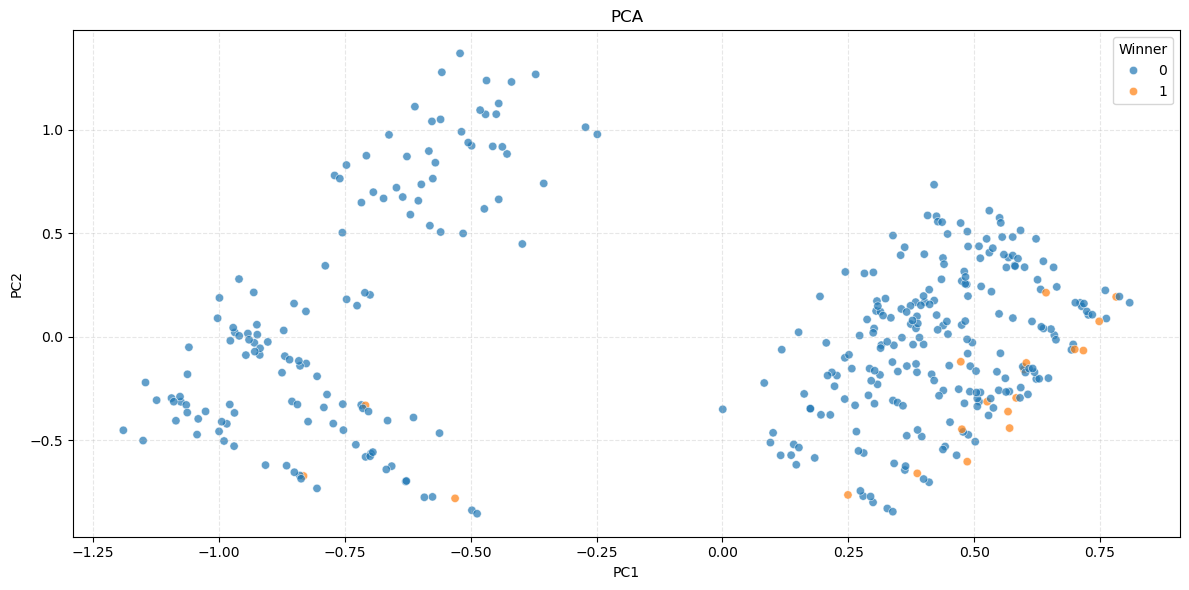

In [469]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Winner', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [470]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.19461432, 0.11331742, 0.0806627 , 0.07214584, 0.0541448 ,
       0.05411529])

In [471]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.19461432, 0.30793174, 0.38859443, 0.46074027, 0.51488507,
       0.56900036])

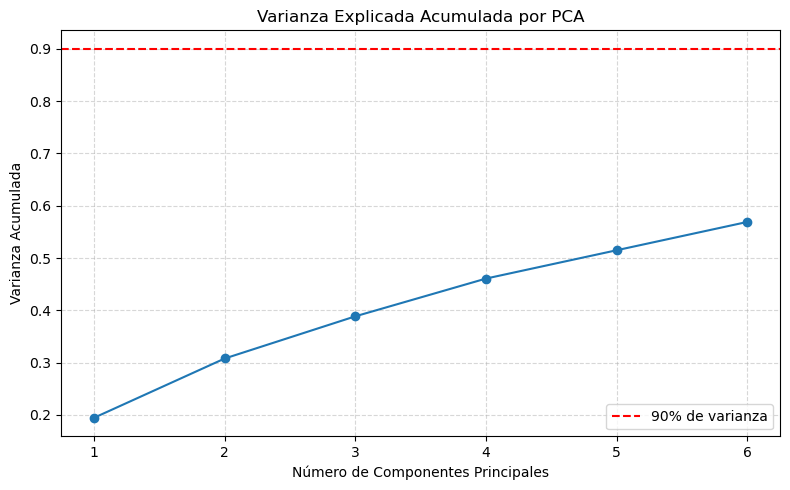

In [472]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
